In [36]:
import torch

# ============================================================
# Dataset Building for Character-Level Language Model
# ============================================================
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [37]:
import torch
import numpy as np

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Sample word list (if not already defined)


# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
# Map every character to a unique integer (reserve 0 for the period)
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print("Vocabulary (itos):", itos)

# Fix random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Context length: how many characters we take to predict the next one
block_size = 8

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        # Start with a context of all zeros (will be updated as we parse the word)
        context = [0] * block_size
        for ch in w + '.':  # Append period as an end-of-word marker
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # Slide the context window: drop the first element, append the current index
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("X shape:", X.shape, "Y shape:", Y.shape)
    return X, Y

# Split the dataset (80% train, 10% dev, 10% test)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

print("Vocab size:", vocab_size)

# -------------------------------
# 2. Custom Neural Network Layers
# -------------------------------

class LinearLayer:
    def __init__(self, f_in, f_out, bias=True):
        self.f_in = f_in
        self.f_out = f_out
        self.bias = bias
        self.w = torch.randn(f_in, f_out, requires_grad=True)
        if bias:
            self.b = torch.zeros(f_out, requires_grad=True)
        else:
            self.b = None

    def __call__(self, x):
        if self.bias:
            return x @ self.w + self.b
        else:
            return x @ self.w

    def parameters(self):
        return [self.w] if self.b is None else [self.w, self.b]

class EmbeddingLayer:
    def __init__(self, n_emb, d_emb):
        # n_emb is the vocabulary size, d_emb is the embedding dimension.
        self.emb = torch.randn(n_emb, d_emb, requires_grad=True)

    def __call__(self, x):
        x = x.long()
        return self.emb[x]

    def parameters(self):
        return [self.emb]

# -------------------------------
# 3. Custom RNN Implementation
# -------------------------------

class RNNCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Weight matrices for input-to-hidden and hidden-to-hidden transitions
        self.W_ih = torch.randn(input_dim, hidden_dim, requires_grad=True)
        self.W_hh = torch.randn(hidden_dim, hidden_dim, requires_grad=True)
        # Biases for the input and hidden transformations
        self.b_ih = torch.zeros(hidden_dim, requires_grad=True)
        self.b_hh = torch.zeros(hidden_dim, requires_grad=True)

    def __call__(self, x, h):
        """
        x: Tensor of shape (batch_size, input_dim) for the current time step.
        h: Tensor of shape (batch_size, hidden_dim) representing the previous hidden state.
        Returns:
            h_new: The updated hidden state (batch_size, hidden_dim)
        """
        h_new = torch.tanh(x @ self.W_ih + h @ self.W_hh + self.b_ih + self.b_hh)
        return h_new

    def parameters(self):
        return [self.W_ih, self.W_hh, self.b_ih, self.b_hh]

class RNN:
    def __init__(self, input_dim, hidden_dim):
        # Use a single RNN cell at every time step.
        self.cell = RNNCell(input_dim, hidden_dim)

    def __call__(self, x, h0=None):
        """
        x: Input tensor with shape (batch_size, seq_len, input_dim)
        h0: Optional initial hidden state (default is zeros), shape: (batch_size, hidden_dim)
        Returns:
            outputs: A tensor containing the hidden state for every time step (batch_size, seq_len, hidden_dim)
            h: The hidden state from the last time step (batch_size, hidden_dim)
        """
        batch_size, seq_len, _ = x.shape
        
        # Initialize h0 as zeros if not provided
        if h0 is None:
            h = torch.zeros(batch_size, self.cell.hidden_dim)
        else:
            h = h0

        outputs = []
        for t in range(seq_len):
            # Process one time step at a time
            x_t = x[:, t, :]  # Shape: (batch_size, input_dim)
            h = self.cell(x_t, h)
            outputs.append(h)
        # Stack the hidden states to form the output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs, h

    def parameters(self):
        return self.cell.parameters()

# -------------------------------
# 4. Composing the RNN Model for Character-Level Prediction
# -------------------------------

class CharRNN:
    def __init__(self, vocab_size, d_emb, hidden_dim):
        # Create an embedding layer (vocab_size x d_emb)
        self.embed = EmbeddingLayer(vocab_size, d_emb)
        # RNN layer that processes the embeddings sequentially
        self.rnn = RNN(d_emb, hidden_dim)

        self.rnn2 = RNN(hidden_dim, hidden_dim)
        # Linear layer mapping from hidden_dim to vocab_size logits
        self.lin = LinearLayer(hidden_dim, vocab_size)

    def __call__(self, x):
        """
        x: Tensor of shape (batch_size, block_size) containing sequences of integer tokens.
        Returns:
            logits: Tensor of shape (batch_size, vocab_size) representing the prediction for the next character.
        """
        # Pass the input through the embedding layer.
        x_emb = self.embed(x)  # Shape: (batch_size, block_size, d_emb)
        
        # Process the embedded sequence with the RNN.
        outputs, h = self.rnn(x_emb)
        
        # For prediction, we use the hidden state from the final time step.
        final_hidden = outputs[:, -1, :]  # Shape: (batch_size, hidden_dim)
        logits = self.lin(final_hidden)   # Shape: (batch_size, vocab_size)
        return logits

    def parameters(self):
        # Collect parameters from all layers.
        return self.embed.parameters() + self.rnn.parameters() + self.lin.parameters()

# -------------------------------
# 5. Testing the Model's Forward Pass
# -------------------------------

# Set hyperparameters for the model
d_emb = 32     # Dimension for embeddings
hidden_dim = 64  # Hidden state dimension

# Instantiate the character RNN model.
model = CharRNN(vocab_size, d_emb, hidden_dim)




Vocabulary (itos): {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
X shape: torch.Size([182778, 8]) Y shape: torch.Size([182778])
X shape: torch.Size([22633, 8]) Y shape: torch.Size([22633])
X shape: torch.Size([22735, 8]) Y shape: torch.Size([22735])
Vocab size: 27


In [38]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

8891


In [39]:
import torch.nn.functional as F

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 17.1764


  10000/ 200000: 2.0711
  20000/ 200000: 2.4426
  30000/ 200000: 2.4193
  40000/ 200000: 1.9763
  50000/ 200000: 2.0416
  60000/ 200000: 2.5680
  70000/ 200000: 2.0609
  80000/ 200000: 2.2333
  90000/ 200000: 2.4029
 100000/ 200000: 2.5740
 110000/ 200000: 1.8119
 120000/ 200000: 2.3949
 130000/ 200000: 2.2732
 140000/ 200000: 2.4088
 150000/ 200000: 2.4634
 160000/ 200000: 1.9793
 170000/ 200000: 1.9148
 180000/ 200000: 2.1512
 190000/ 200000: 2.7503


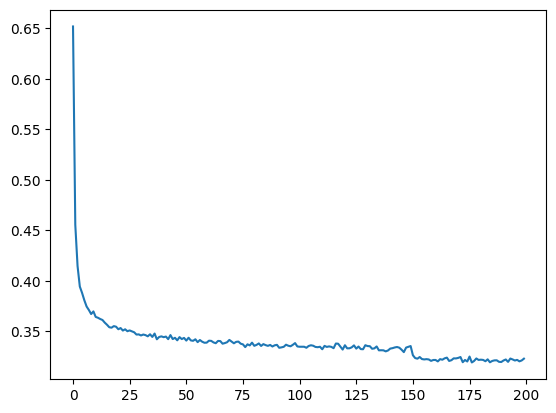

In [40]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [41]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.parameters():
  layer.requires_grad = False

In [42]:
Xtr.shape, Xte.shape

(torch.Size([182778, 8]), torch.Size([22735, 8]))

In [43]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.106175661087036
val 2.385399580001831


In [56]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ralex.
anndeline.
sayoe.
killel.
hernyer.
conavian.
assri.
toakoretzionkien.
qolasia.
gunsly.
kaaly.
beekai.
yakrieman.
jenslynn.
adenobran.
zorickdesh.
amarole.
kyra.
geavii.
calex.
